# Machine Learning Models

## Setup

In [1]:
# pip installs

In [311]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import datasets
from sklearn.cluster import KMeans
import sklearn.metrics as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

from tqdm import tqdm
import pandas as pd
import humanize
from datetime import datetime, timedelta
import time
import numpy as np
import seaborn as sns
import ast
import matplotlib.pyplot as plt

In [350]:
df = pd.read_csv("training_data.csv")
df = df.drop(columns=df.columns[0])
df.head()

,runtime,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,run_max_mem_rss_bytes,area,steps_fire
0,5475,4503,0.10,600,65.0,2.235,1.00,1934680,560976.0,600
1,9737,11382,0.05,600,90.0,4.470,0.90,2470180,1981888.0,600
2,501,3937,0.12,600,270.0,2.235,0.95,517424,359488.0,600
3,4325,4921,0.10,600,137.0,3.000,1.10,2454040,1053216.0,600
4,9008,14997,0.15,600,360.0,4.470,1.00,3919432,648024.0,600


Now let's try to make some models and see what we can do!

In [313]:
for column in df.columns:
    if column != "runtime":
        df[column] = normalize(df[column])

y = df["runtime"]

X = df.drop(columns=["runtime"])
pred = {}
models = {}

In [314]:
df

,runtime,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,run_max_mem_rss_bytes,area,steps_fire
0,5475,0.050966,0.303030,1.0,0.241645,0.051458,0.833333,0.074582,0.046235,1.0
1,9737,0.128999,0.151515,1.0,0.305913,0.144583,0.750000,0.100625,0.293084,1.0
2,501,0.044546,0.363636,1.0,0.768638,0.051458,0.791667,0.005656,0.011231,1.0
3,4325,0.055708,0.303030,1.0,0.426735,0.083333,0.916667,0.099840,0.131749,1.0
4,9008,0.170005,0.454545,1.0,1.000000,0.144583,0.833333,0.171107,0.061357,1.0
...,...,...,...,...,...,...,...,...,...,...
1562,526,0.045317,0.303030,1.0,0.228792,0.051458,0.750000,0.000000,0.000000,1.0
1563,8858,0.128738,0.151515,1.0,0.460154,0.125958,0.833333,0.100649,0.293084,1.0
1564,577,0.044546,0.212121,1.0,0.691517,0.051458,0.791667,0.005659,0.011231,1.0
1565,11663,0.309009,0.454545,1.0,0.228792,0.144583,0.750000,0.171151,0.061357,1.0


In [315]:
TEST_RATIO = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO,random_state=42)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(len(X_train), len(X_test), len(y_train), len(y_test))

1096 471 1096 471


In [316]:
def print_score(pred, true):
    print("Mean Squared Error:".ljust(22," "),round(mean_squared_error(true, pred),5))
    print("Mean Absolute Error:".ljust(22," "), round(mean_absolute_error(true, pred),5))
    
def convert(seconds):
    return humanize.naturaldelta(timedelta(seconds=seconds))

def show_diff(predictions,y_test,n=25):
    print("PREDICTION\t RESULT\t\t DIFFERENCE")
    print("-"*45)
    for i in range(0,n):
        print(convert(predictions[i]), "\t",convert(int(y_test[i])), "\t", convert(y_test[i] - predictions[i]))

def show_plots(predictions, y_test, s=4):
    plt.subplot(211)
    plt.title("Test Results and Predictions")
    plt.scatter(range(len(y_test)),y_test,s=s)
    plt.xlabel("X_test[i]")
    plt.ylabel("correct answer")
    plt.subplot(212)
    plt.ylim([0,50000])
    plt.scatter(range(len(predictions)),predictions,s=s)
    plt.ylabel("predictions")
    plt.show()

# K Means Clustering

In [317]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [318]:
# ------ experiment with cluster amount ---------- #
n_clusters = 10
# ------ experiment with cluster amount ---------- #

model = KMeans(n_clusters=n_clusters, n_init=10)
model = model.fit(X_train,y_train)

In [319]:
prediction = model.predict(X_test)

In [320]:
prediction_mapping = (prediction / n_clusters) * y_test.max()
results = pd.DataFrame({
    "prediction": prediction_mapping,
    "answer":y_test,
    "difference": y_test-prediction_mapping
})
results.head(4)

,prediction,answer,difference
0,43110.4,1567,-41543.4
1,0.0,11449,11449.0
2,43110.4,2287,-40823.4
3,32332.8,592,-31740.8


In [321]:
pred["kMeans"] = model.predict(X_test)
models["kMeans"] = model
print_score(prediction, y_test)

Mean Squared Error:    86441718.29512
Mean Absolute Error:   6426.51168


### Now let's try for many values of k

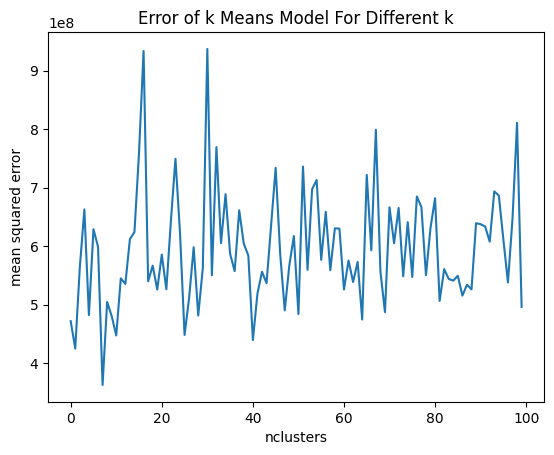

In [322]:
def get_mse(n_clusters):
    global X_test, y_test, X_train, y_train
    n_clusters = 30
    model = KMeans(n_clusters=n_clusters, n_init='auto')
    model.fit(X_train,y_train)
    prediction = model.predict(X_test)
    
    prediction_mapping = (prediction / n_clusters) * y_test.max()
    return mean_squared_error(y_true=y_test, y_pred=prediction_mapping)

get_mse(30)
clusters = list(range(0,100))
MSE = []
for i in clusters:
    MSE.append(round(get_mse(i),2))

plt.title("Error of k Means Model For Different k")
plt.xlabel("nclusters")
plt.ylabel("mean squared error")
plt.plot(clusters,MSE)
plt.show()

so it looks like K means clustering has a long way to go and more clusters has no real effect on the accuracy. Let's try some other methods

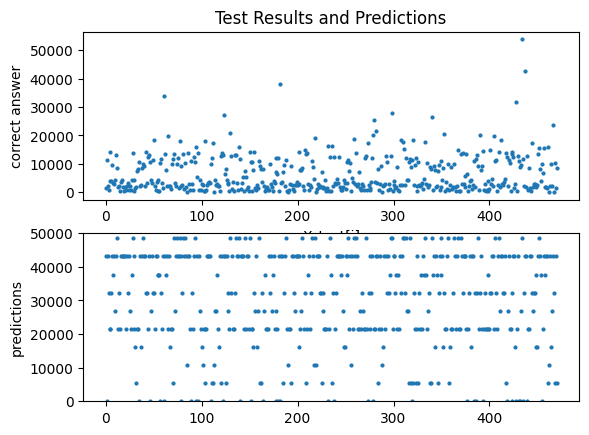

In [323]:
show_plots(prediction_mapping,y_test)

# Multi Linear Regression

In [324]:
import numpy as np

In [325]:
model = LinearRegression()
model = model.fit(X_train,y_train)

In [326]:
predictions = model.predict(X_test)
print_score(predictions,y_test)

Mean Squared Error:    12611079.91817
Mean Absolute Error:   2354.7136


In [327]:
pred["multi-linear"] = model.predict(X_test)
models["multi-linear"] = model
print_score(predictions, y_test)

Mean Squared Error:    12611079.91817
Mean Absolute Error:   2354.7136


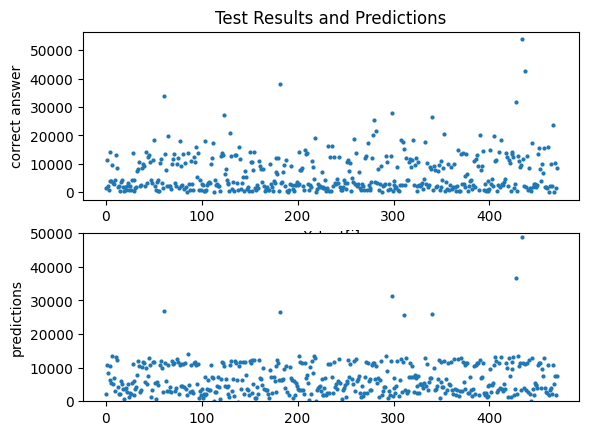

In [328]:
show_plots(predictions,y_test,s=4)

In [329]:
print(len(X_test))

471


# Neural Net

In [330]:
def normalize(series):
    return MinMaxScaler().fit_transform(np.array(series).reshape(-1,1))

y_train = normalize(y_train)

In [331]:
# example of training a final regression model
from keras.models import Sequential
from keras.layers import Dense

# generate regression dataset
X, y = make_regression(n_samples=100, n_features=9, noise=0.1, random_state=1)
scalarX, scalarY = MinMaxScaler(), MinMaxScaler()
scalarX.fit(X)
scalarY.fit(y.reshape(100,1))
X = scalarX.transform(X)
y = scalarY.transform(y.reshape(100,1))

# define and fit the final model
model = Sequential()
model.add(Dense(9, input_shape=(9,), activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
h = model.fit(X_train, y_train, epochs=100, verbose=1, validation_split = 0.1)

# CHANGE LAST LAYER

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0119
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 0.0118 - val_loss: 0.0111
Epoch 3/100
31/31 [==============================] - 0s 889us/step - loss: 0.0112 - val_loss: 0.0109
Epoch 4/100
31/31 [==============================] - 0s 919us/step - loss: 0.0108 - val_loss: 0.0103
Epoch 5/100
31/31 [==============================] - 0s 911us/step - loss: 0.0102 - val_loss: 0.0100
Epoch 6/100
31/31 [==============================] - 0s 953us/step - loss: 0.0099 - val_loss: 0.0096
Epoch 7/100
31/31 [==============================] - 0s 863us/step - loss: 0.0096 - val_loss: 0.0096
Epoch 8/100
31/31 [==============================] - 0s 909us/step - loss: 0.0096 - val_loss: 0.0090
Epoch 9/100
31/31 [==============================] - 0s 869us/step - loss: 0.0092 - val_loss: 0.0090
Epoch 10/100
31/31 [==============================] - 0s 881us/step - loss: 0.0088 - val_loss: 

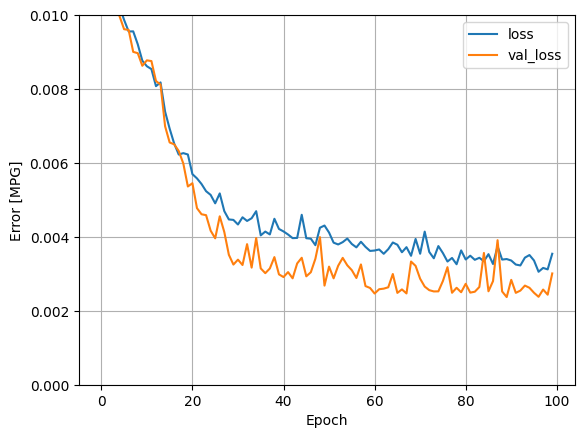

In [332]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1e-2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(h)

In [333]:
predictions = model.predict(X_test, verbose=0)
print_score(predictions, y_test)

# Mean Squared Error:    0.03558335327632717
# Mean Absolute Error:   0.16927700703786802

Mean Squared Error:    86507148.26239
Mean Absolute Error:   6431.91557


In [334]:
pred["keras"] = model.predict(X_test)
models["keras"] = model
print_score(predictions, y_test)

15/15 [==============================] - 0s 456us/step
Mean Squared Error:    86507148.26239
Mean Absolute Error:   6431.91557


In [335]:
print_score(predictions,y_test)

Mean Squared Error:    86507148.26239
Mean Absolute Error:   6431.91557


In [336]:

# Mean Squared Error:    86506857.70903887
# Mean Absolute Error:   6431.912279610207

# Mean Squared Error:    86506687.77386706
# Mean Absolute Error:   6431.89729009321

# Mean Squared Error:    86506881.56282507
# Mean Absolute Error:   6431.909780053204

# Mean Squared Error:    86506690.3881022
# Mean Absolute Error:   6431.898311441057

# Mean Squared Error:    86506774.30611314
# Mean Absolute Error:   6431.903274915572


# SVM

In [337]:
model = SVR(kernel='rbf')
model = model.fit(X_train,y_train)

/root/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [338]:
predictions = model.predict(X_test)
print_score(predictions,y_test)

Mean Squared Error:    86506616.47815
Mean Absolute Error:   6431.89298


In [339]:
pred["SVM"] = model.predict(X_test)
models["SVM"] = model
print_score(predictions, y_test)

Mean Squared Error:    86506616.47815
Mean Absolute Error:   6431.89298


In [340]:
show_diff(predictions,y_test)

PREDICTION	 RESULT		 DIFFERENCE
---------------------------------------------
a day 	 26 minutes 	 26 minutes
a moment 	 3 hours 	 3 hours
a moment 	 38 minutes 	 38 minutes
a day 	 9 minutes 	 9 minutes
a moment 	 3 hours 	 3 hours
a moment 	 an hour 	 an hour
a moment 	 an hour 	 an hour
a moment 	 2 hours 	 2 hours
a moment 	 51 minutes 	 51 minutes
a moment 	 45 minutes 	 45 minutes
a moment 	 an hour 	 an hour
a moment 	 3 hours 	 3 hours
a moment 	 2 hours 	 2 hours
a moment 	 27 minutes 	 27 minutes
a moment 	 35 minutes 	 35 minutes
a moment 	 8 minutes 	 8 minutes
a moment 	 56 minutes 	 56 minutes
a moment 	 an hour 	 an hour
a moment 	 32 minutes 	 32 minutes
a day 	 8 minutes 	 8 minutes
a moment 	 30 minutes 	 30 minutes
a moment 	 13 minutes 	 13 minutes
a moment 	 33 minutes 	 33 minutes
a moment 	 54 minutes 	 54 minutes
a day 	 12 minutes 	 12 minutes


seems like this only predicts something like the best guess of the dataset, not actually doing much prediction

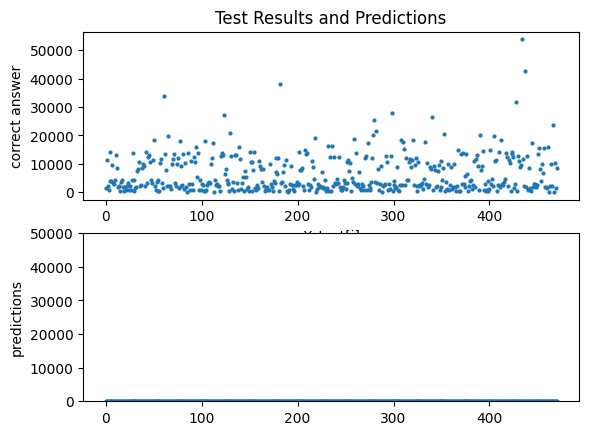

In [341]:
show_plots(predictions,y_test)

# Decision Trees

In [342]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model = model.fit(X_train, y_train)

In [343]:
predictions = model.predict(X_test)
print_score(predictions,y_test)

Mean Squared Error:    86506781.80014
Mean Absolute Error:   6431.90933


In [344]:
pred["DecisionTree"] = model.predict(X_test)
models["DecisionTree"] = model
print_score(predictions, y_test)

Mean Squared Error:    86506781.80014
Mean Absolute Error:   6431.90933


In [345]:
show_diff(predictions,y_test)

PREDICTION	 RESULT		 DIFFERENCE
---------------------------------------------
a moment 	 26 minutes 	 26 minutes
a moment 	 3 hours 	 3 hours
a moment 	 38 minutes 	 38 minutes
a moment 	 9 minutes 	 9 minutes
a moment 	 3 hours 	 3 hours
a moment 	 an hour 	 an hour
a moment 	 an hour 	 an hour
a moment 	 2 hours 	 2 hours
a moment 	 51 minutes 	 51 minutes
a moment 	 45 minutes 	 45 minutes
a moment 	 an hour 	 an hour
a moment 	 3 hours 	 3 hours
a moment 	 2 hours 	 2 hours
a moment 	 27 minutes 	 27 minutes
a moment 	 35 minutes 	 35 minutes
a moment 	 8 minutes 	 8 minutes
a moment 	 56 minutes 	 56 minutes
a moment 	 an hour 	 an hour
a moment 	 32 minutes 	 32 minutes
a moment 	 8 minutes 	 8 minutes
a moment 	 30 minutes 	 30 minutes
a moment 	 13 minutes 	 13 minutes
a moment 	 33 minutes 	 33 minutes
a moment 	 54 minutes 	 54 minutes
a moment 	 12 minutes 	 12 minutes


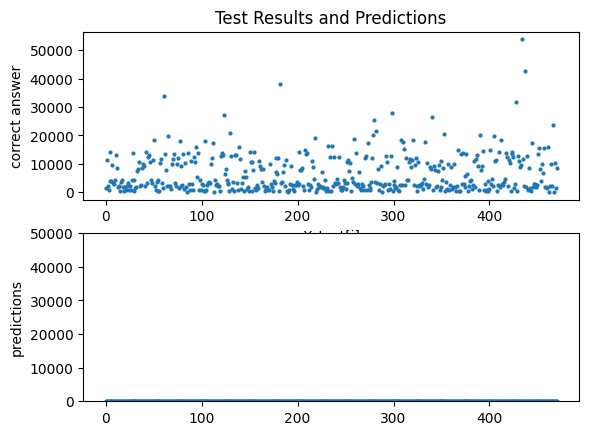

In [346]:
show_plots(predictions,y_test)

# Compare Plots

In [347]:
# compare = pd.DataFrame(pred)
compare = pd.DataFrame({
    "name":pred.keys(), 
    "mean absolute":np.nan,
    "mse":np.nan,
})
compare = compare.set_index("name")

In [348]:
# compare["accuracy"] = compare.apply(lambda row: accuracy_score(y_pred=pred[row.name],y_true=y_test)*100,axis=1)
compare["mse"] = compare.apply(lambda row: mean_squared_error(y_pred=pred[row.name],y_true=y_test),axis=1)
compare["mean absolute"] = compare.apply(lambda row: mean_absolute_error(y_pred=pred[row.name],y_true=y_test),axis=1)

In [349]:
compare.sort_values(by='mean absolute',ascending=True)

,mean absolute,mse
name,,
multi-linear,2354.713603,1.261108e+07
kMeans,6426.511677,8.644172e+07
SVM,6431.892981,8.650662e+07
DecisionTree,6431.909334,8.650678e+07
keras,6431.915574,8.650715e+07
